In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt

folder_dir = 'C:/Users/kimin/Desktop/cora'
idx_features_labels = np.genfromtxt(folder_dir + '/cora.content',dtype=np.dtype(str))
edges_unordered = np.genfromtxt(folder_dir + '/cora.cites',dtype=np.dtype(int))

In [86]:
paper_id = np.array(idx_features_labels[:, 0], dtype=np.int)
id2idx = {p_id:i for i, p_id in enumerate(paper_id)}
idx2id = {i:p_id for i, p_id in enumerate(paper_id)}

label_list = list(set(idx_features_labels[:, -1]))
index2label = {i:label for i, label in enumerate(label_list)}
label2index = {label:i for i, label in enumerate(label_list)}
target = [label2index[label] for label in idx_features_labels[:, -1]]
feature = np.array(idx_features_labels[:, 1:-1], dtype=np.float)
def feature_normalize(feature):
    s = 1 / feature.sum(axis=1)
    return feature * s.reshape(-1, 1)

feature = feature_normalize(feature)

In [87]:
def gcn_adj_normalization(adj):
    adj += np.eye(len(adj))
    dig_rsqrt = np.power(adj.sum(axis=1), -0.5)
    dig_rsqrt[np.isinf(dig_rsqrt)] = 0.
    dig_rsqrt = np.diag(dig_rsqrt)
    return dig_rsqrt @ adj @ dig_rsqrt


adj = np.empty((len(paper_id), len(paper_id)), dtype=np.float)

for edge in edges_unordered:
    citee_idx = id2idx[edge[0]]
    citer_idx = id2idx[edge[1]]
    adj[citer_idx][citee_idx] = 1
    adj[citee_idx][citer_idx] = 1 # convert to undirected graph
    
adj = gcn_adj_normalization(adj)


In [88]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(0.1 * torch.randn(in_features, out_features))
        
    def forward(self, g, x):
        return torch.matmul(g, torch.matmul(x, self.W))
    
    
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.a1 = nn.ReLU()
        self.gcn2 = GCNLayer(hidden_features, hidden_features)
        self.a2 = nn.ReLU()
        self.gcn3 = GCNLayer(hidden_features, hidden_features)
        self.a3 = nn.ReLU()
        self.gcn4 = GCNLayer(hidden_features, num_classes)
    
    def forward(self, g, h):
        h = self.a1(self.gcn1(g, h))
        h = h + self.a2(self.gcn2(g, h))
        h = h + self.a3(self.gcn3(g, h))
        h = self.gcn4(g, h)
        return h
    

In [89]:
idx_train = range(140)
idx_test = range(200, 1200)
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)


X = torch.Tensor(feature)
A = torch.Tensor(adj)
target = torch.LongTensor(target)
gcn = GCN(X.shape[1], 64, 7)
solver = torch.optim.Adam(gcn.parameters(),  lr=1e-2)

In [90]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(100):
    solver.zero_grad()
    Y = gcn(A, X)
    loss = F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean')
    loss.backward()
    solver.step()
    train_loss.append(loss.item())
    test_loss.append(F.cross_entropy(Y[idx_test], target[idx_test], reduction='mean').item())
    train_acc.append((Y[idx_train].argmax(dim=1) == target[idx_train]).sum() / len(idx_train))
    test_acc.append((Y[idx_test].argmax(dim=1) == target[idx_test]).sum() / len(idx_test))
    


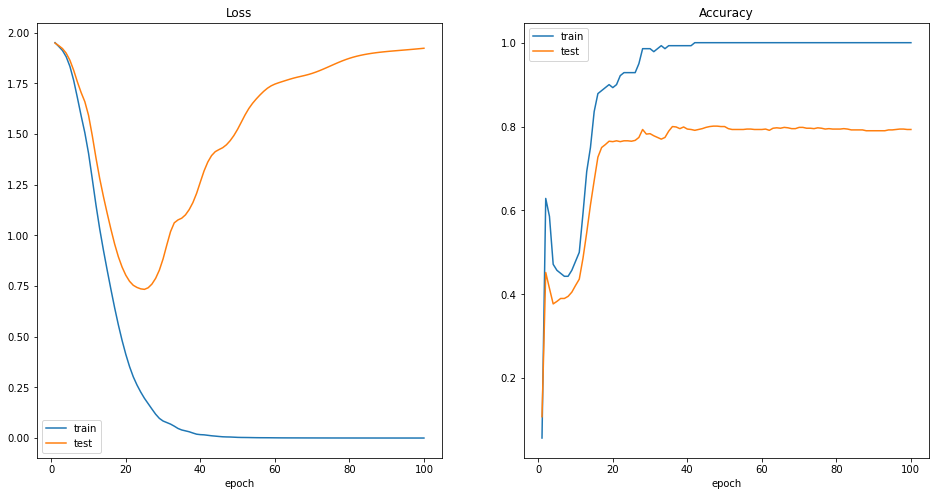

In [92]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(train_loss) + 1), train_loss, label='train')
ax.plot(range(1, len(test_acc) + 1), test_loss, label='test')

ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.legend()

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(train_acc) + 1), train_acc, label='train')
ax.plot(range(1, len(test_acc) + 1), test_acc, label='test')
ax.set_title('Accuracy')
ax.set_xlabel('epoch')

ax.legend()
plt.show()
